In [1]:
!gdown 1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h

Downloading...
From: https://drive.google.com/uc?id=1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h
To: /content/title_brand.csv
100% 97.3M/97.3M [00:02<00:00, 42.7MB/s]


In [2]:
!gdown 1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW

Downloading...
From: https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
To: /content/train_data.csv
100% 635M/635M [00:11<00:00, 53.6MB/s]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [45]:
data = pd.read_csv("train_data.csv").drop(
    ["reviewTime", "unixReviewTime"], axis=1
)
extra = pd.read_csv("title_brand.csv")

In [46]:
data["feeling"] = data["overall"].apply(
    lambda x: 1 if x in [4, 5] else -1 if x in [1, 2] else 0
)
data

,overall,vote,verified,reviewerID,asin,style,reviewerName,reviewText,summary,feeling
0,2,NaN,False,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,-1
1,5,NaN,True,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1
2,4,NaN,True,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1
3,5,NaN,True,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1
4,5,NaN,True,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1
...,...,...,...,...,...,...,...,...,...,...
838939,5,NaN,True,A1OOVLE2KZ6KGA,B01HJCN1EI,NaN,Puddzee,These are my favorite charging cords for a few...,Worth the price.,1
838940,1,NaN,True,A77K1B31UAQ29,B01HJCN1EI,NaN,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING,-1
838941,3,NaN,True,A2SVXUVUAWUDK2,B01HJH42KU,NaN,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...,0
838942,5,2.0,True,A2HUZO7MQAY5I2,B01HJH40WU,NaN,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,1


<h3>1. Distribution of overall</h6>

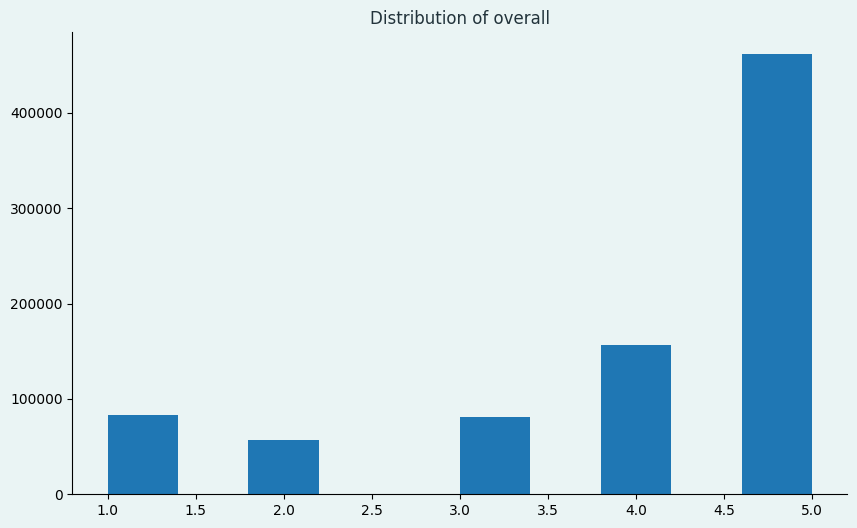

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data["overall"])
ax.set_title("Distribution of overall", color="#22333b", fontsize=12)
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

As we can see, the dataset is **not balanced**, for example, half of our data has an overall rating of 5. If the data used for modeling is not balanced, our model will be **biased**, which is undesirable. Therefore, for modeling, we need to select an approximately **equal** number of data from each category. This task is not performed in this section and will be done during modeling.

<h3>2. Word Clouds</h6>

In [4]:
nlp = spacy.load("en_core_web_sm")


def process_text(text):
    doc = nlp(text)
    tokens = [
        token.text.lower() for token in doc if not token.is_stop and token.is_alpha
    ]
    return tokens


words_to_remove = [
    "use",
    "phone",
    "cable",
    "camera",
    "usb",
    "tv",
    "laptop",
    "speaker",
    "screen",
    "charger",
    "mouse",
    "plug",
    "ipad",
    "adapter",
    "bluetooth",
    "computer",
    "drive",
    "keyboard",
    "wireless",
    "headphones",
]

<h5>Tokenizing the reviews and counting the frequency of words</h5>

In [7]:
word_freq_bad = defaultdict(int)

df_bad = data[data["feeling"] == -1]
batch_size = 100
num_batches = len(df_bad) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_bad["reviewText"][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(text) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_bad[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_bad["reviewText"][num_batches * batch_size :]
remaining_tokens = [process_text(text) for text in remaining_texts]
for tokens in remaining_tokens:
    for token in tokens:
        word_freq_bad[token] += 1

freq_bad = pd.DataFrame(list(word_freq_bad.items()), columns=["Word", "Frequency"])
freq_bad.to_csv("freq_bad.csv")

100%|██████████| 1397/1397 [53:12<00:00,  2.28s/it]


<h5>Word Cloud of reviews with overall rating 1 & 2</h5>



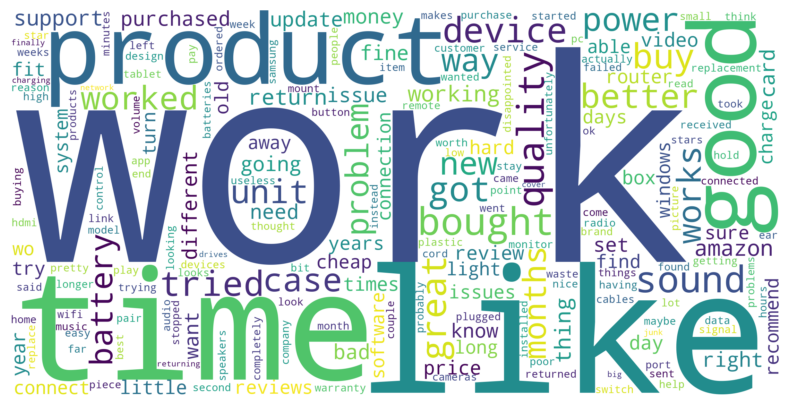

In [25]:
mask = np.array(Image.open("min.jpg"))

for word in words_to_remove:
    if word in word_freq_bad:
        del word_freq_bad[word]
wordcloud_bad_shape = WordCloud(
    width=2400, height=2400, background_color="white", mask=mask, colormap="viridis"
).generate_from_frequencies(word_freq_bad)
wordcloud_bad = WordCloud(
    width=2400, height=1200, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq_bad)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bad, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud_bad_shape.to_file("min_shape_output2.png")
wordcloud_bad.to_file("min_output2.png")

<h5>Tokenizing the reviews and counting the frequency of words</h5>

In [12]:
word_freq_soso = defaultdict(int)

df_soso = data[data["feeling"] == 0]
batch_size = 100
num_batches = len(df_soso) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_soso["reviewText"][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(text) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_soso[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_soso["reviewText"][num_batches * batch_size :]
remaining_tokens = [process_text(text) for text in remaining_texts]
for tokens in remaining_tokens:
    for token in tokens:
        word_freq_soso[token] += 1

freq_soso = pd.DataFrame(list(word_freq_soso.items()), columns=["Word", "Frequency"])
freq_soso.to_csv("freq_soso.csv")

100%|██████████| 812/812 [33:18<00:00,  2.46s/it]


<h5>Word Cloud of reviews with overall rating 3</h5>

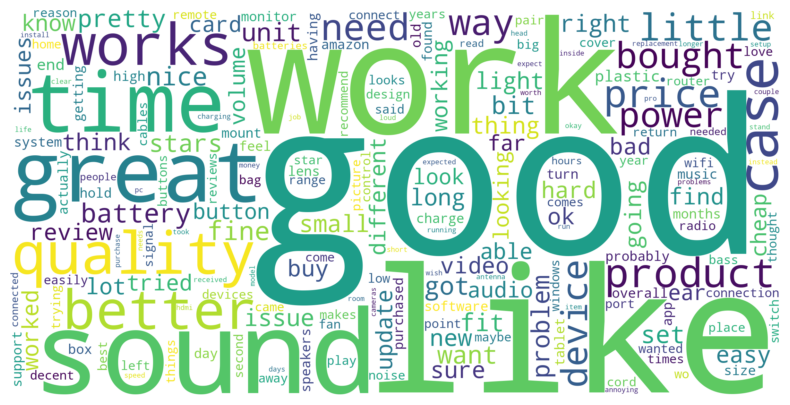

In [26]:
mask = np.array(Image.open("equal.jpg"))

for word in words_to_remove:
    if word in word_freq_soso:
        del word_freq_soso[word]
wordcloud_soso_shape = WordCloud(
    width=2400, height=2400, background_color="white", mask=mask, colormap="viridis"
).generate_from_frequencies(word_freq_soso)
wordcloud_soso = WordCloud(
    width=2400, height=1200, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq_soso)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_soso, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud_soso_shape.to_file("equal_shape_output2.png")
wordcloud_soso.to_file("equal_output2.png")

<h5>Tokenizing the reviews and counting the frequency of words</h5>

In [14]:
word_freq_good = defaultdict(int)

df_good = data[data["feeling"] == 1]
batch_size = 100
num_batches = len(df_good) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_good["reviewText"][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(text) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_good[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_good["reviewText"][num_batches * batch_size :]
remaining_tokens = [process_text(text) for text in remaining_texts]

for tokens in remaining_tokens:
    for token in tokens:
        word_freq_good[token] += 1


freq_good = pd.DataFrame(list(word_freq_good.items()), columns=["Word", "Frequency"])
freq_good.to_csv("freq_good.csv")

100%|██████████| 6179/6179 [3:46:11<00:00,  2.20s/it]  


<h5>Word Cloud of reviews with overall rating 4 & 5</h5>

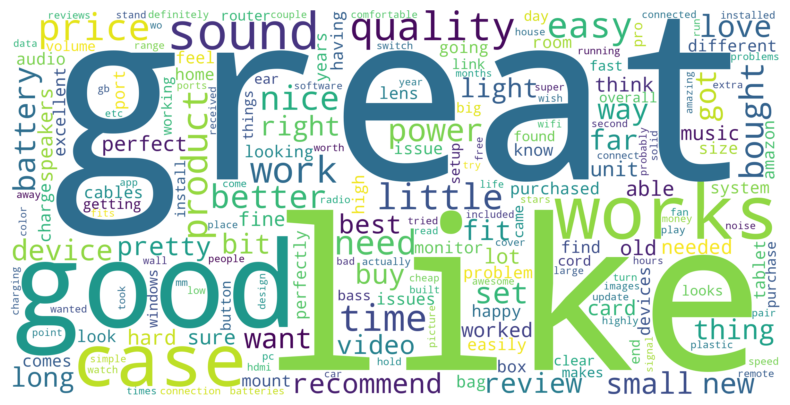

In [27]:
mask = np.array(Image.open("plus.jpg"))

for word in words_to_remove:
    if word in word_freq_good:
        del word_freq_good[word]
wordcloud_good_shape = WordCloud(
    width=2400, height=2400, background_color="white", mask=mask, colormap="viridis"
).generate_from_frequencies(word_freq_good)
wordcloud_good = WordCloud(
    width=2400, height=1200, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq_good)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_good, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud_good.to_file("plus2_output.png")
wordcloud_good_shape.to_file("plus2_shape_output.png")

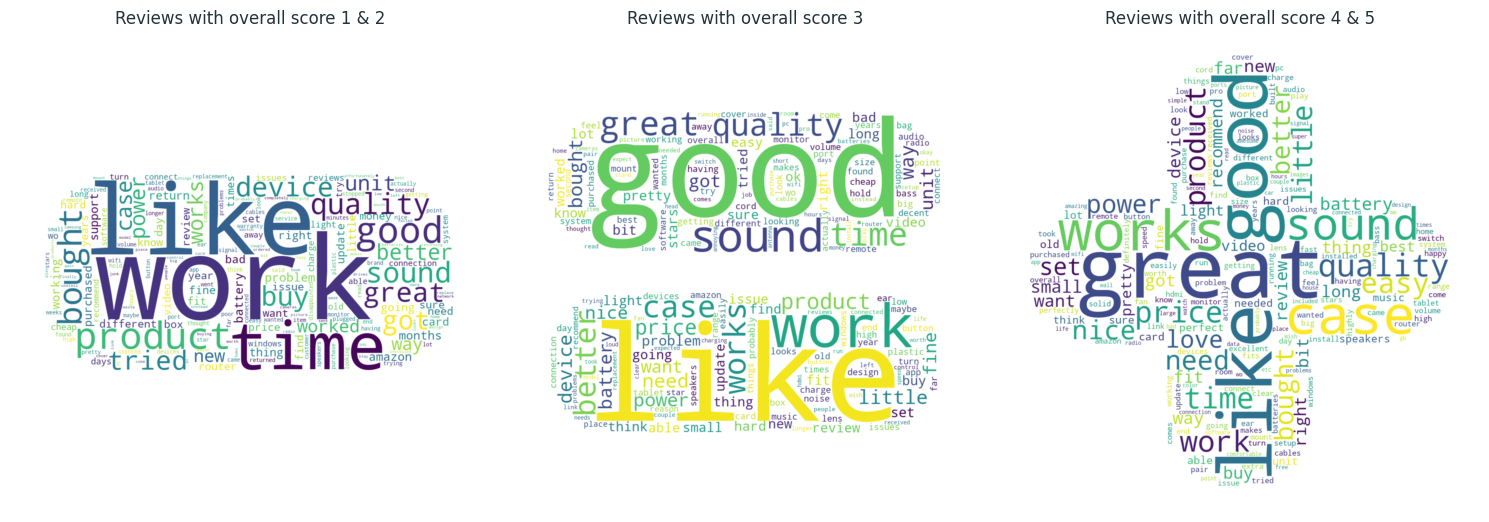

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

axs[0].imshow(wordcloud_bad_shape, interpolation="bilinear")
axs[0].set_title("Reviews with overall score 1 & 2", color="#22333b", fontsize=12)
axs[0].axis("off")

axs[1].imshow(wordcloud_soso_shape, interpolation="bilinear")
axs[1].set_title("Reviews with overall score 3", color="#22333b", fontsize=12)
axs[1].axis("off")

axs[2].imshow(wordcloud_good_shape, interpolation="bilinear")
axs[2].set_title("Reviews with overall score 4 & 5", color="#22333b", fontsize=12)
axs[2].axis("off")

plt.tight_layout()
plt.show()

<h5>Tokenizing the summaries of reviews and counting the frequency of words</h5>

In [8]:
word_freq_bad_summary = defaultdict(int)

df_bad = data[data["feeling"] == -1]
batch_size = 100
num_batches = len(df_bad) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_bad["summary"][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(str(text)) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_bad_summary[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_bad["summary"][num_batches * batch_size :]
remaining_tokens = [process_text(text) for text in remaining_texts]
for tokens in remaining_tokens:
    for token in tokens:
        word_freq_bad_summary[token] += 1

freq_bad_summary = pd.DataFrame(list(word_freq_bad_summary.items()), columns=["Word", "Frequency"])
freq_bad_summary.to_csv("freq_bad_summary.csv")

100%|██████████| 1397/1397 [16:26<00:00,  1.42it/s]


In [22]:
words_to_remove = [
    "use",
    "phone",
    "cable",
    "camera",
    "usb",
    "tv",
    "laptop",
    "speaker",
    "screen",
    "charger",
    "mouse",
    "plug",
    "ipad",
    "adapter",
    "bluetooth",
    "computer",
    "drive",
    "keyboard",
    "wireless",
    "headphones",
    "great",
    "good",
    "quality",
    "work",
    "works",
    "product"
]

<h5>Word Cloud of summaries of reviews with overall rating 1 & 2</h5>

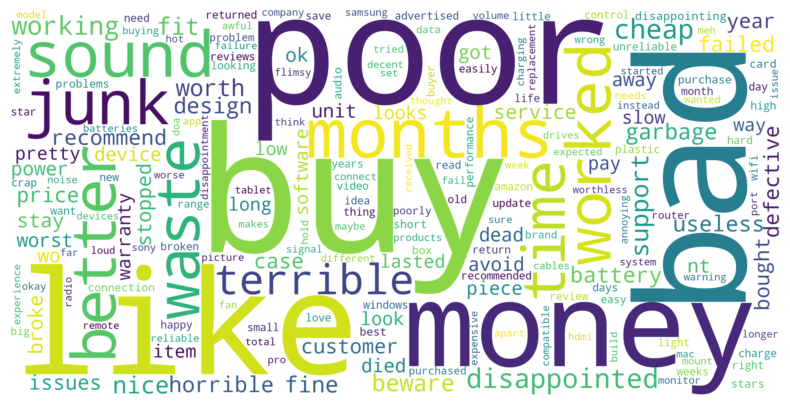

In [27]:
mask = np.array(Image.open("min.jpg"))

for word in words_to_remove:
    if word in word_freq_bad_summary:
        del word_freq_bad_summary[word]
wordcloud_bad_summary_shape = WordCloud(
    width=2400, height=2400, background_color="white", mask=mask, colormap="viridis"
).generate_from_frequencies(word_freq_bad_summary)
wordcloud_bad_summary = WordCloud(
    width=2400, height=1200, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq_bad_summary)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bad_summary, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud_bad_summary.to_file("min_summary_output.png")
wordcloud_bad_summary_shape.to_file("min_summary_shape_output.png")

<h5>Tokenizing the summaries of reviews and counting the frequency of words</h5>

In [12]:
word_freq_soso_summary = defaultdict(int)

df_soso = data[data["feeling"] == 0]
batch_size = 100
num_batches = len(df_soso) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_soso["summary"][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(str(text)) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_soso_summary[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_soso["summary"][num_batches * batch_size :]
remaining_tokens = [process_text(text) for text in remaining_texts]
for tokens in remaining_tokens:
    for token in tokens:
        word_freq_soso_summary[token] += 1

freq_soso_summary = pd.DataFrame(list(word_freq_soso_summary.items()), columns=["Word", "Frequency"])
freq_soso_summary.to_csv("freq_soso_summary.csv")

100%|██████████| 812/812 [10:52<00:00,  1.24it/s]


<h5>Word Cloud of summaries of reviews with overall rating 3</h5>

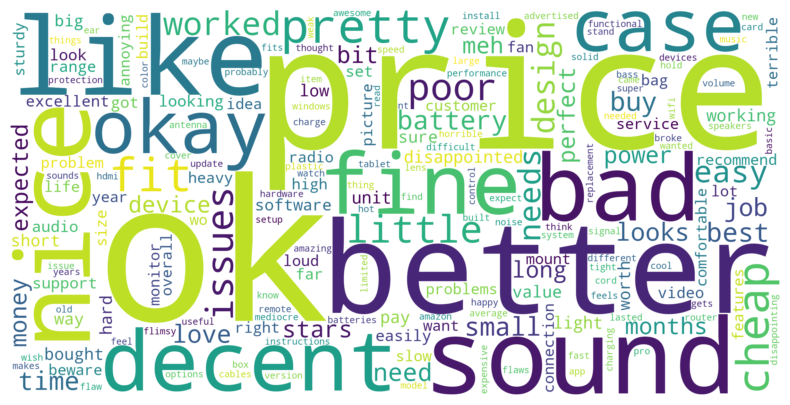

In [28]:
mask = np.array(Image.open("equal.jpg"))

for word in words_to_remove:
    if word in word_freq_soso_summary:
        del word_freq_soso_summary[word]
wordcloud_soso_summary_shape = WordCloud(
    width=2400, height=2400, background_color="white", mask=mask, colormap="viridis"
).generate_from_frequencies(word_freq_soso_summary)
wordcloud_soso_summary = WordCloud(
    width=2400, height=1200, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq_soso_summary)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_soso_summary, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud_soso_summary.to_file("equal_summary_output.png")
wordcloud_soso_summary_shape.to_file("equal_summary_shape_output.png")

<h5>Tokenizing the summaries of reviews and counting the frequency of words</h5>

In [14]:
word_freq_good_summary = defaultdict(int)

df_good = data[data["feeling"] == 1]
batch_size = 100
num_batches = len(df_good) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_good["summary"][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(str(text)) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_good_summary[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_good["summary"][num_batches * batch_size :]
remaining_tokens = [process_text(text) for text in remaining_texts]
for tokens in remaining_tokens:
    for token in tokens:
        word_freq_good_summary[token] += 1

freq_good_summary = pd.DataFrame(list(word_freq_good_summary.items()), columns=["Word", "Frequency"])
freq_good_summary.to_csv("freq_good_summary.csv")

100%|██████████| 6179/6179 [1:20:05<00:00,  1.29it/s]


<h5>Word Cloud of summaries of reviews with overall rating 4 & 5</h5>

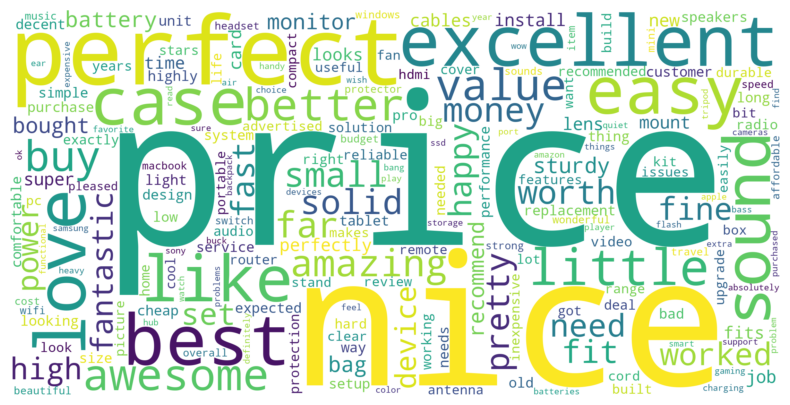

In [29]:
mask = np.array(Image.open("plus.jpg"))

for word in words_to_remove:
    if word in word_freq_good_summary:
        del word_freq_good_summary[word]
wordcloud_good_summary_shape = WordCloud(
    width=2400, height=2400, background_color="white", mask=mask, colormap="viridis"
).generate_from_frequencies(word_freq_good_summary)
wordcloud_good_summary = WordCloud(
    width=2400, height=1200, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq_good_summary)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_good_summary, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud_good_summary.to_file("plus_summary_output.png")
wordcloud_good_summary_shape.to_file("plus_summary_shape_output.png")

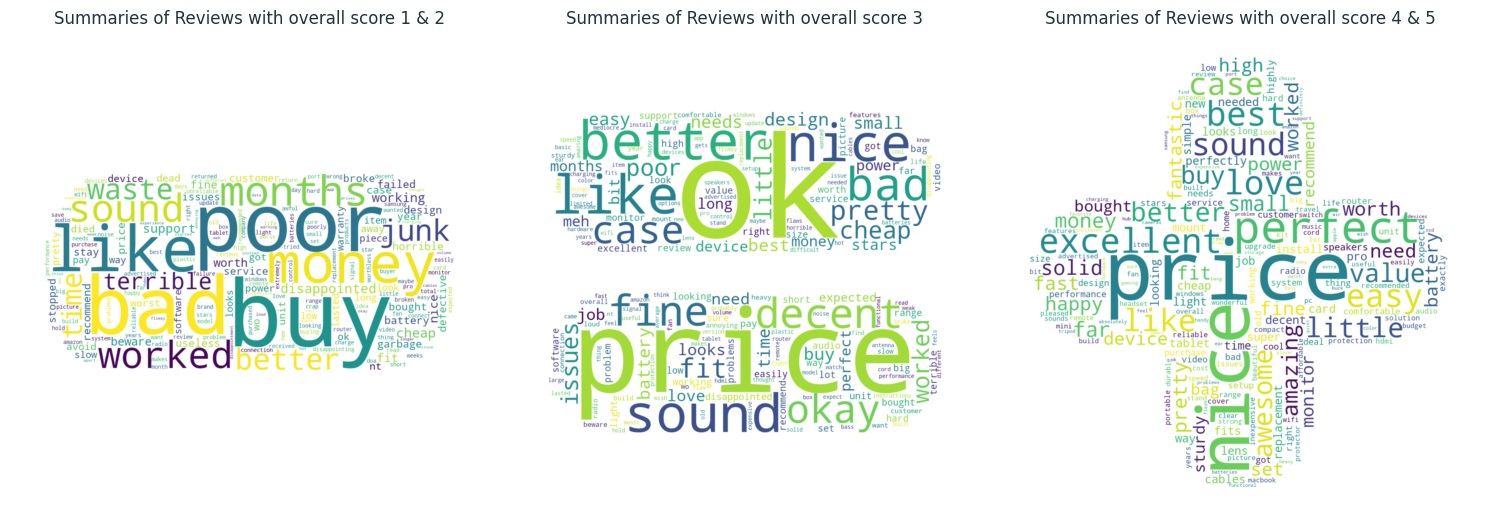

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

axs[0].imshow(wordcloud_bad_summary_shape, interpolation="bilinear")
axs[0].set_title("Summaries of Reviews with overall score 1 & 2", color="#22333b", fontsize=12)
axs[0].axis("off")

axs[1].imshow(wordcloud_soso_summary_shape, interpolation="bilinear")
axs[1].set_title("Summaries of Reviews with overall score 3", color="#22333b", fontsize=12)
axs[1].axis("off")

axs[2].imshow(wordcloud_good_summary_shape, interpolation="bilinear")
axs[2].set_title("Summaries of Reviews with overall score 4 & 5", color="#22333b", fontsize=12)
axs[2].axis("off")

plt.tight_layout()
plt.show()

<h3>3. Top 10 person who had the most useful reviews</h3>

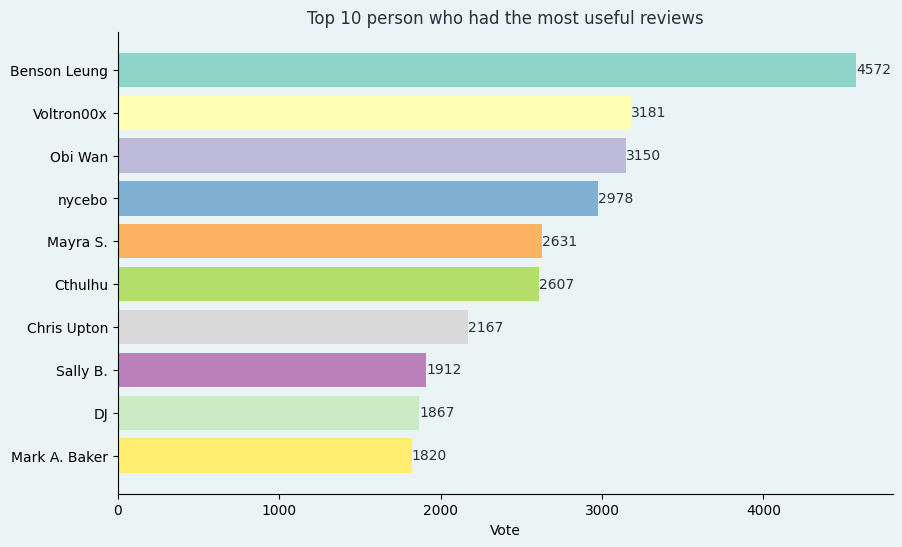

In [123]:
df = data.dropna(subset=["vote"])
df["vote"] = (
    df["vote"]
    .apply(lambda x: float(x.replace(",", "")) if isinstance(x, str) else x)
    .astype(int)
)
vote_sum = df.groupby("reviewerID")["vote"].sum()
vote_sum = vote_sum.sort_values(ascending=False).head(10)
result = pd.merge(
    vote_sum,
    df[["reviewerID", "reviewerName"]].drop_duplicates(),
    on="reviewerID",
    how="left",
)
result["reviewerName"].unique()


fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(result)))

bars = ax.barh(result["reviewerName"], result["vote"], color=colors)
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width}",
        ha="left",
        va="center",
        color="#22333b",
    )

ax.set_title(
    "Top 10 person who had the most useful reviews", color="#22333b", fontsize=12
)
ax.set_xlabel("Vote")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.invert_yaxis()

<h3>4. Review Text Length Distribution</h3>

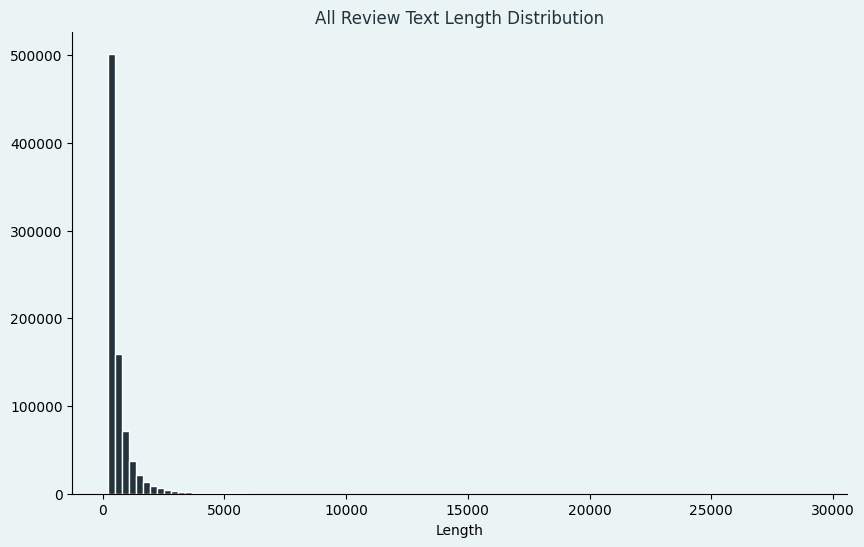

In [121]:
review_lengths = data["reviewText"].apply(len)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(review_lengths, bins=100, edgecolor="w", color="#22333b")
ax.set_title("All Review Text Length Distribution", color="#22333b", fontsize=12)
ax.set_xlabel("Length")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

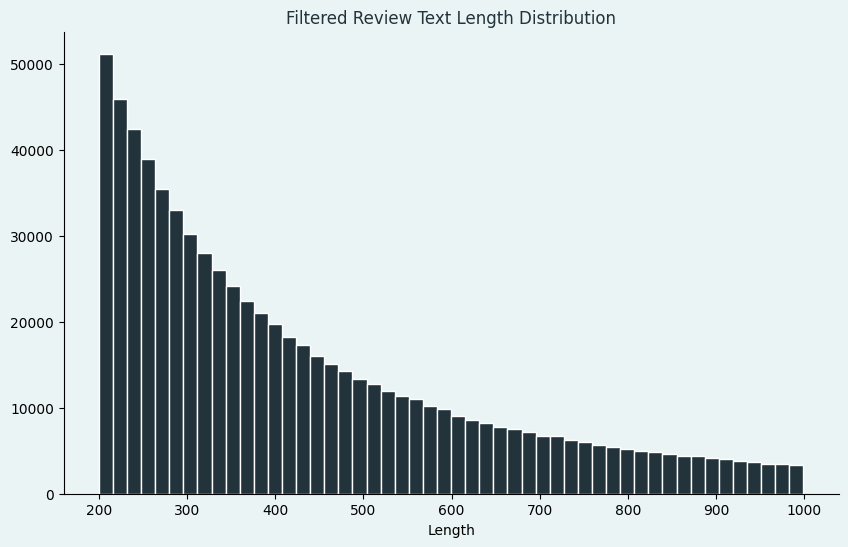

In [120]:
review_lengths = review_lengths[review_lengths < 1000]

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(review_lengths, bins=50, edgecolor="w", color="#22333b")
ax.set_title("Filtered Review Text Length Distribution", color="#22333b", fontsize=12)
ax.set_xlabel("Length")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

<h3>5. Top 10 products that have achieved the highest number of overall ratings of 5.</h3>

In [57]:
top10_product = (
    data[data["overall"] == 5]
    .groupby("asin")["overall"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)

result = pd.merge(top10_product, extra.drop_duplicates(), on="asin", how="left")
result = result.rename(columns={"overall": "count of 5 overall"})
result = result[["title", "brand", "count of 5 overall"]]

pd.set_option("max_colwidth", 200)
result.head(10)

,title,brand,count of 5 overall
0,"OontZ Angle 3 Enhanced Stereo Edition IPX5 Splashproof Portable Bluetooth Speaker with Volume Booster AMP 10 Watts Power, Custom Bass Radiator, 100' Wireless Range Bluetooth 4.2",Cambridge Soundworks,1163
1,NETGEAR N300 WiFi Range Extender (EX2700),NETGEAR,659
2,Roku Streaming Stick (3600R) - HD Streaming Player with Quad-Core Processor,Roku,600
3,StarTech USB 2.0 to SATA IDE Adapter (USB2SATAIDE),StarTech,598
4,"Logitech M570 Wireless Trackball Mouse &ndash; Ergonomic Design with Sculpted Right-hand Shape, Compatible with Apple Mac and Microsoft Windows Computers, USB Unifying Receiver, Dark Gray",Logitech,552
5,Samsung 850 EVO 500GB 2.5-Inch SATA III Internal SSD (MZ-75E500B/AM),Samsung,529
6,"ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up to 3167 Mbps) with MU-MIMO to ensure Lag-Free Gaming, AiProtection network security powered by Trend Micro, Adaptive QoS and Parental Control (RT-AC3...",Asus,471
7,"VideoSecu ML531BE TV Wall Mount for Most 27&quot;-55&quot; LED LCD Plasma Flat Screen Monitor up to 88 lb VESA 400x400 with Full Motion Swivel Articulating 20 in Extension Arm, HDMI Cable &amp; Bu...",VideoSecu,448
8,Arlo - Wireless Home Security Camera System | Indoor/Outdoor | 2 camera kit (Discontinued),"Arlo Technologies, Inc",433
9,Samsung 850 EVO 250GB 2.5-Inch SATA III Internal SSD (MZ-75E250B/AM),Samsung,431


<h3>6. Top 10 brands that had the highest number of reviews and the highest average overall rating.</h3>

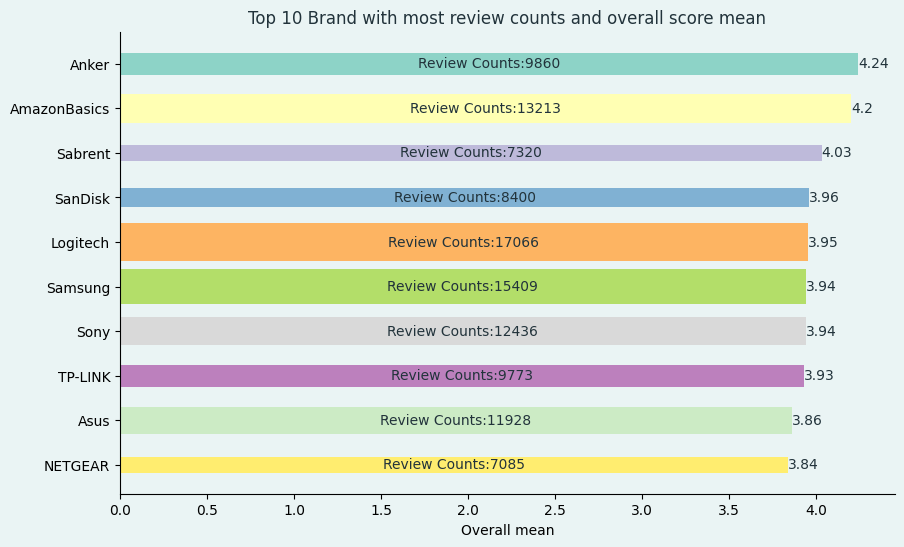

In [116]:
df = pd.merge(
    data[["asin", "overall"]], extra[["asin", "brand"]], on="asin", how="left"
)
result = (
    df.groupby("brand")
    .agg({"asin": "count", "overall": "mean"})
    .sort_values(by="asin", ascending=False)
    .head(10)
)
result = result.sort_values(by="overall", ascending=False).head(10).reset_index()
result["overall"] = result["overall"].round(2)
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(result)))

bars = ax.barh(
    result["brand"],
    width=result["overall"],
    height=(result["asin"] / 20000),
    color=colors,
)
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width}",
        color="#22333b",
        ha="left",
        va="center",
    )
    ax.text(
        width / 2,
        bar.get_y() + bar.get_height() / 2,
        f"Review Counts:{ int(bar.get_height()*20000)}",
        color="#22333b",
        ha="center",
        va="center",
    )


ax.set_title(
    "Top 10 brands that had the highest number of reviews and the highest average overall rating",
    color="#22333b",
    fontsize=12,
)
ax.set_xlabel("Overall mean")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.invert_yaxis()

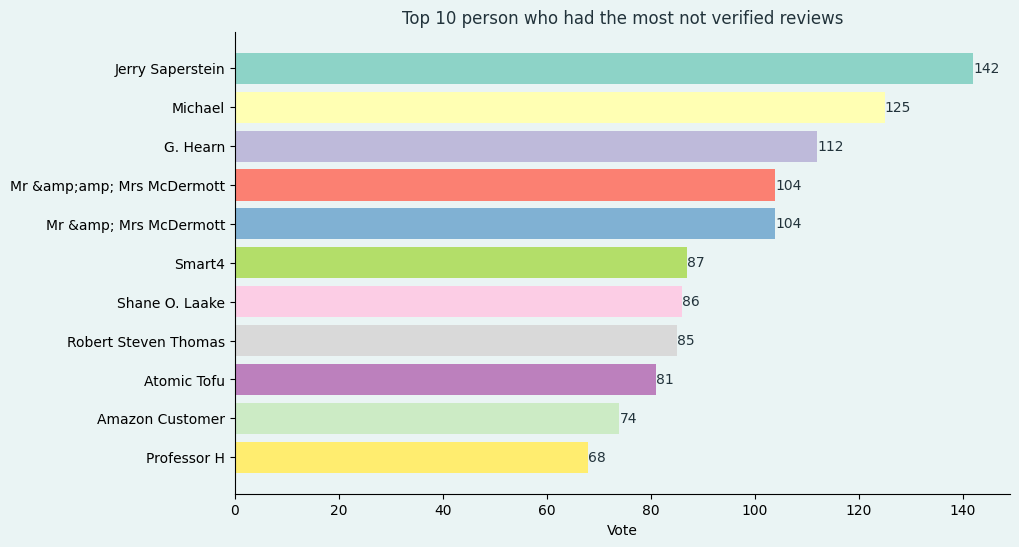

In [44]:
not_verified_count = data[data["verified"] == False].groupby("reviewerID")["verified"].count()
not_verified_count = not_verified_count.sort_values(ascending=False).head(10)
result = pd.merge(
    not_verified_count,
    data[["reviewerID", "reviewerName"]].drop_duplicates(),
    on="reviewerID",
    how="left",
)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(result)))

bars = ax.barh(result["reviewerName"], result["verified"], color=colors)
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width}",
        ha="left",
        va="center",
        color="#22333b",
    )

ax.set_title(
    "Top 10 person who had the most not verified reviews", color="#22333b", fontsize=12
)
ax.set_xlabel("Vote")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.invert_yaxis()

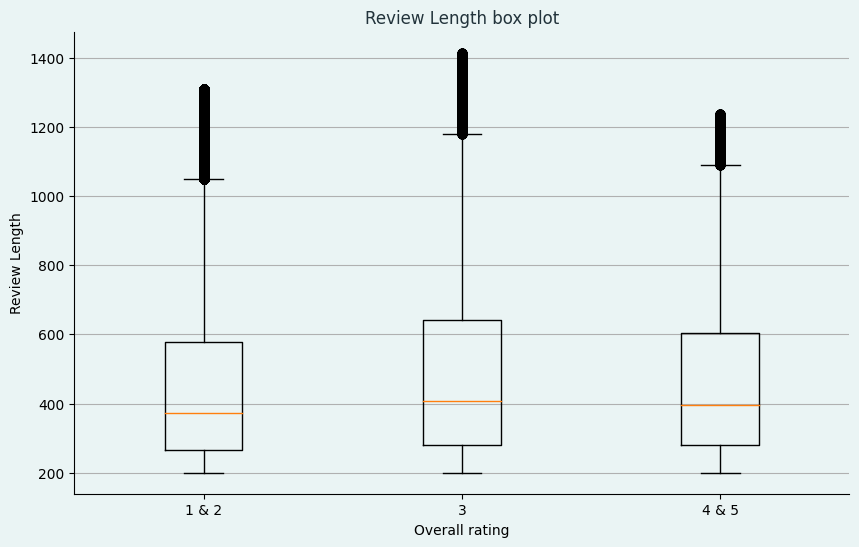

In [69]:
def remove_outliers(arr, threshold=1):
    mean = np.mean(arr)
    std = np.std(arr)
    filtered_arr = [x for x in arr if (mean - threshold * std < x < mean + threshold * std)]
    return filtered_arr

good_reviews = data[data['overall'].isin([4, 5])]
soso_reviews = data[data['overall'].isin([3])]
bad_reviews = data[data['overall'].isin([1, 2])]

good_reviews_length = remove_outliers(good_reviews['reviewText'].apply(len))
soso_reviews_length = remove_outliers(soso_reviews['reviewText'].apply(len))
bad_reviews_length = remove_outliers(bad_reviews['reviewText'].apply(len))

fig, ax = plt.subplots(figsize=(10, 6))

ax.boxplot([good_reviews_length, soso_reviews_length, bad_reviews_length], labels=['1 & 2', '3', '4 & 5'])

ax.set_title(
    "Review Length box plot", color="#22333b", fontsize=12
)
ax.set_xlabel("Overall rating")
ax.set_ylabel("Review Length")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.yaxis.grid(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

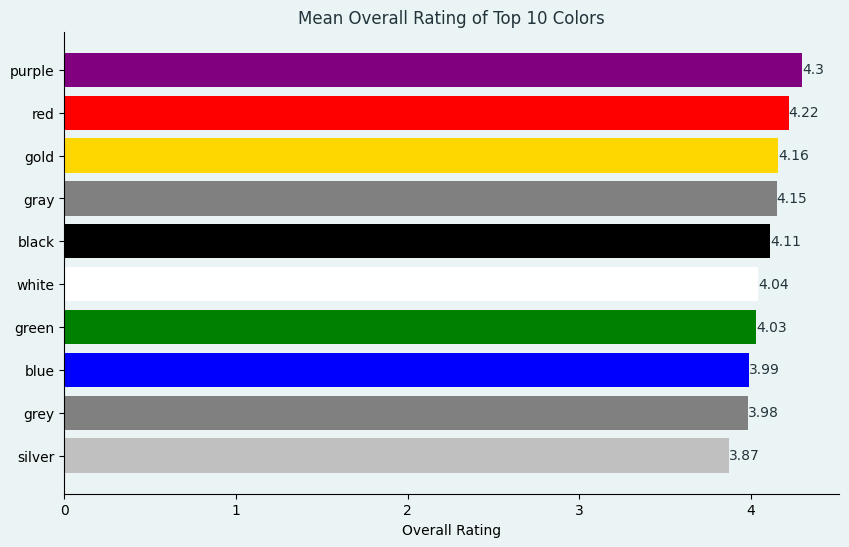

In [104]:
import ast

df = data.dropna(subset="style")
df["style"] = df["style"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else None
)
df["color"] = df["style"].apply(
    lambda x: x.get("Color:") if isinstance(x, dict) and "Color:" in x else None
)

color_counts = df["color"].str.lower().value_counts().reset_index()
color_counts.columns = ["color", "count"]
sorted_colors = color_counts.sort_values(by="count", ascending=False).head(10)

mean_ratings = (
    sorted_colors.merge(df, how="left", on="color")
    .groupby("color")["overall"]
    .mean()
    .reset_index()
)
sorted_mean_ratings = mean_ratings.sort_values(by="overall", ascending=False)

colors = sorted_mean_ratings["color"].str.strip()
mean_overall_ratings = sorted_mean_ratings["overall"].round(2)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(colors, mean_overall_ratings, color=colors)
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width}",
        ha="left",
        va="center",
        color="#22333b",
    )

ax.set_title("Mean Overall Rating of Top 10 Colors", color="#22333b", fontsize=12)
ax.set_xlabel("Overall Rating")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.invert_yaxis()